# Step 1: Collect image paths and labels (for splitting)

In [24]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Collect image paths and labels (for splitting)
def collect_image_paths(data_dir):
    image_paths = []
    labels = []
    class_names = ['husky', 'wolf']
    train_dir = os.path.join(data_dir, 'train')
    for class_id, class_name in enumerate(class_names):
        folder = os.path.join(train_dir, class_name)
        if not os.path.exists(folder):
            print(f"Error: Folder not found - {folder}")
            return [], []
        img_names = os.listdir(folder)
        if not img_names:
            print(f"Warning: No images found in {folder}")
        for img_name in img_names:
            img_path = os.path.join(folder, img_name)
            image_paths.append(img_path)
            labels.append(class_id)  # 0 for husky, 1 for wolf
    if not image_paths:
        print("Error: No images found in dataset")
        return [], []
    return image_paths, labels

# Step 2: Check if split is already done and Load data with normalization

In [25]:
data_dir = 'data'
total_images = sum(len(os.listdir(os.path.join(data_dir, 'train', cls))) for cls in ['husky', 'wolf'])
test_husky_dir = os.path.join(data_dir, 'test', 'husky')
test_wolf_dir = os.path.join(data_dir, 'test', 'wolf')
test_images = sum(len(os.listdir(dir)) for dir in [test_husky_dir, test_wolf_dir] if os.path.exists(dir))

if total_images > 0 and (not os.path.exists(test_husky_dir) or not os.path.exists(test_wolf_dir) or test_images == 0):
    print("Setting up initial 80/20 split...")
    image_paths, labels = collect_image_paths(data_dir)

    # Split into train and test sets
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )

    print(f"Training files: {len(train_paths)}")
    print(f"Test files: {len(test_paths)}")
    print("Training set distribution:", np.bincount(train_labels))
    print("Test set distribution:", np.bincount(test_labels))

    # Create test directories
    os.makedirs(test_husky_dir, exist_ok=True)
    os.makedirs(test_wolf_dir, exist_ok=True)

    # Move test files
    for img_path, label in zip(test_paths, test_labels):
        class_name = 'husky' if label == 0 else 'wolf'
        dest_dir = os.path.join(data_dir, 'test', class_name)
        shutil.move(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

    print("Files moved to new structure.")
else:
    print("Split structure already exists. Skipping file movement.")

# Step 3: 
def load_data(data_dir, split='train', target_size=(256, 256)):
    images = []
    labels = []
    class_names = ['husky', 'wolf']
    split_dir = os.path.join(data_dir, split)
    for class_id, class_name in enumerate(class_names):
        folder = os.path.join(split_dir, class_name)
        try:
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img, target_size)
                    # Normalize: Scale pixel values from [0, 255] to [0, 1]
                    img_normalized = img_resized / 255.0
                    images.append(img_normalized)
                    labels.append(class_id)
        except FileNotFoundError:
            print(f"Error: Folder not found - {folder}")
            return None, None
    return np.array(images), np.array(labels)

# Load train and test sets
X_train, y_train = load_data(data_dir, split='train')
X_test, y_test = load_data(data_dir, split='test')

if X_train is not None:
    print(f"Loaded {len(X_train)} training images")
if X_test is not None:
    print(f"Loaded {len(X_test)} test images")




Split structure already exists. Skipping file movement.
Loaded 80 training images
Loaded 20 test images


# Step 4: Plot samples to verify

Training samples:


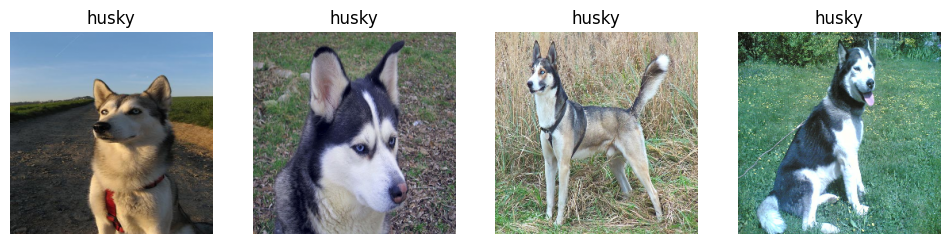

Test samples:


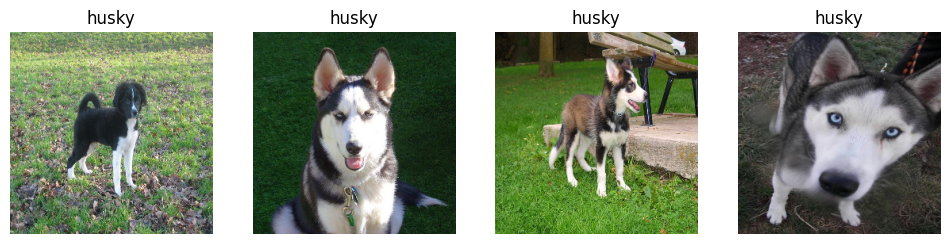

In [26]:
def plot_samples(X, y, class_names=['husky', 'wolf'], num_samples=4):
    plt.figure(figsize=(12, 3))
    for i in range(min(num_samples, len(X))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[i])
        plt.title(class_names[y[i]])
        plt.axis('off')
    plt.show()

if X_train is not None and len(X_train) > 0:
    print("Training samples:")
    plot_samples(X_train, y_train)
if X_test is not None and len(X_test) > 0:
    print("Test samples:")
    plot_samples(X_test, y_test)

# Step 5: Add augmentation for training data

In [27]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define augmentations
transform = A.Compose([
    A.Rotate(limit=20, p=0.5),  # Equivalent to rotation_range=20
    A.HorizontalFlip(p=0.5),    # Equivalent to horizontal_flip=True
    A.RandomResizedCrop((256, 256), scale=(0.8, 1.0), p=0.5),  # ✅ Fixed tuple issue
])

# Function to apply augmentations
def augment_images(images):
    augmented_images = []
    for img in images:
        augmented = transform(image=img)["image"]
        augmented_resized = cv2.resize(augmented, (256, 256))  # ✅ Fix inconsistent sizes
        augmented_images.append(augmented_resized)
    return np.stack(augmented_images)  # ✅ Ensures consistent shape

# Apply to dataset (assuming X_train is a NumPy array of images)
aug_train_images = augment_images(X_train)


# Function to plot images
def plot_samples(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

# Show augmented samples
print("Augmented training samples:")
plot_samples(aug_train_images)


Augmented training samples:


# Step 6 : Creating Logistic Regression model

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Flatten the image data for logistic regression
X_train_flattened = X_train.reshape(aug_train_images.shape[0], -1)  # Flatten to (n_samples, height * width * channels)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)     # Flatten to (n_samples, height * width * channels)

# Step 2: Define the hyperparameter grid for tuning (without solver)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization type (only l1 and l2 supported by liblinear)
    'max_iter': [100, 500, 1000]   # Maximum number of iterations
}

# Step 3: Initialize the Logistic Regression model with a fixed solver
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)

# Step 4: Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    scoring='accuracy',  # Metric to optimize
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    return_train_score=True  # Include train scores for completeness
)

# Step 5: Fit the Grid Search to the training data
grid_search.fit(X_train_flattened, y_train)

# Step 6: Extract and display all hyperparameter combinations and results
print("Hyperparameter Tuning Results:")
print("| C     | Penalty | Max Iter | Mean CV Accuracy | Std CV Accuracy |")
print("|-------|---------|----------|------------------|-----------------|")
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    mean_score = grid_search.cv_results_['mean_test_score'][i]
    std_score = grid_search.cv_results_['std_test_score'][i]
    print(f"| {params['C']:.2f} | {params['penalty']} | {params['max_iter']} | {mean_score:.4f} | {std_score:.4f} |")

# Step 7: Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Step 8: Evaluate the best model on the test set
y_pred = best_model.predict(X_test_flattened)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['husky', 'wolf']))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Hyperparameter Tuning Results:
| C     | Penalty | Max Iter | Mean CV Accuracy | Std CV Accuracy |
|-------|---------|----------|------------------|-----------------|
| 0.01 | l1 | 100 | 0.5000 | 0.0000 |
| 0.01 | l2 | 100 | 0.9125 | 0.0848 |
| 0.01 | l1 | 500 | 0.5000 | 0.0000 |
| 0.01 | l2 | 500 | 0.9125 | 0.0848 |
| 0.01 | l1 | 1000 | 0.5000 | 0.0000 |
| 0.01 | l2 | 1000 | 0.9125 | 0.0848 |
| 0.10 | l1 | 100 | 0.5000 | 0.0000 |
| 0.10 | l2 | 100 | 0.8875 | 0.1146 |
| 0.10 | l1 | 500 | 0.5000 | 0.0000 |
| 0.10 | l2 | 500 | 0.8875 | 0.1146 |
| 0.10 | l1 | 1000 | 0.5000 | 0.0000 |
| 0.10 | l2 | 1000 | 0.8875 | 0.1146 |
| 1.00 | l1 | 100 | 0.8750 | 0.1046 |
| 1.00 | l2 | 100 | 0.9000 | 0.1225 |
| 1.00 | l1 | 500 | 0.8750 | 0.1046 |
| 1.00 | l2 | 500 | 0.9000 | 0.1225 |
| 1.00 | l1 | 1000 | 0.8750 | 0.1046 |
| 1.00 | l2 | 1000 | 0.9000 | 0.1225 |
| 10.00 | l1 | 100 | 0.8250 | 0.1649 |
| 10.00 | l2 | 100 | 0.9000 | 0.1225 |
| 10.00 | l1 | 500 | 0.8250 | 0.1649 |
| 10.00 | l2 | 500 | 0.900

# Test Cell

In [29]:
test_path = 'path/to/test'

def evaluate_test(test_path):
    X_test_custom, y_test_custom = load_data(test_path, target_size=(256, 256))
    X_test_custom_flat = X_test_custom.reshape(X_test_custom.shape[0], -1)
    y_pred_custom = best_model.predict(X_test_custom_flat)
    acc = accuracy_score(y_test_custom, y_pred_custom)
    print(f"Custom Test Accuracy: {acc:.4f}")
    return acc

# Call during "Run All"
print(evaluate_test(test_path))

Error: Folder not found - path/to/test\train\husky


AttributeError: 'NoneType' object has no attribute 'reshape'